In [ ]:
!pip install -qq transformers tokenizers optuna regex

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 52.6 MB/s 
     |████████████████████████████████| 308 kB 78.4 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 895 kB 46.2 MB/s 
     |████████████████████████████████| 596 kB 67.6 MB/s 
     |████████████████████████████████| 209 kB 66.4 MB/s 
     |████████████████████████████████| 80 kB 11.9 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 149 kB 71.7 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 112 kB 65.5 MB/s 


In [ ]:
import time
import gc
import json
import requests
import matplotlib.pyplot as plt
from matplotlib import ticker
from tqdm.notebook import tqdm
from IPython.display import clear_output

import torch
import random
import torch.nn as nn
from sklearn.utils import class_weight
from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config, get_linear_schedule_with_warmup
from transformers import logging
from torch.utils.data import Dataset, random_split
import numpy as np
import pandas as pd

#import transformers as ppb
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

logging.set_verbosity_error()
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clean data and remove duplicates

df = pd.read_csv('train.csv')
print(df.shape) 
df = df.drop_duplicates(subset=['comment_text'])
print(f"Without duplicates {df.shape}") 
stop = stopwords.words('english')
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stop) and len(word)>2]))
df[['id', 'comment_text', 'toxicity']].to_csv('cleaned_train.csv', index=False)
df.head()

(34647, 3)
Without duplicates (34581, 3)


,id,comment_text,toxicity
0,0,fuck self righteous creep,3
1,1,stop stop goddam vandalism hell pay,2
2,2,agree shortcomings certainly breath fresh air ...,0
3,3,would like verfiability link http waytooloud c...,0
4,4,think consensus one certain followed posting h...,0


In [ ]:
df.isna().sum()

id              0
comment_text    0
toxicity        0
dtype: int64

<function matplotlib.pyplot.show>

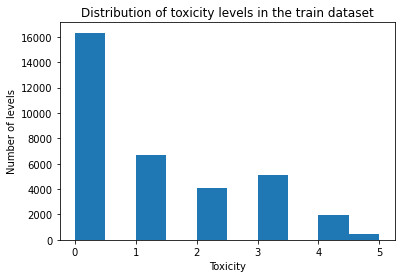

In [ ]:
plt.xlabel('Toxicity')
plt.ylabel('Number of levels')
plt.hist(df["toxicity"])
plt.title('Distribution of toxicity levels in the train dataset')
plt.savefig('Toxicity_distribution.png')
plt.show

In [ ]:
#Function to Create Wordcloud

def create_wordcloud(text):

    mask = np.array(Image.open("cloud.png"))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white",
                   mask = mask,
                   max_words=300,
                   stopwords=stopwords,
                   repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    display(Image.open("wc.png"))



Word Cloud Saved Successfully


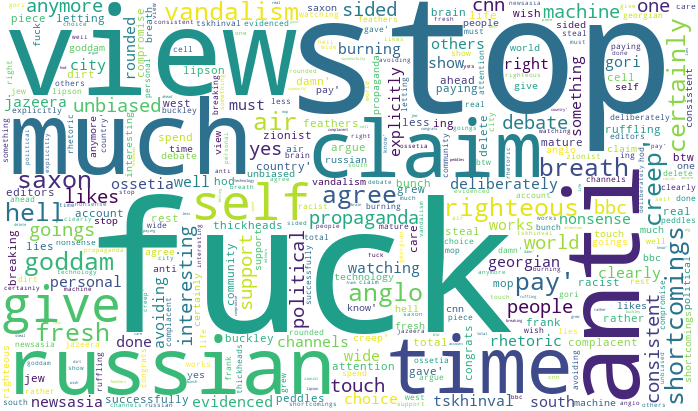

In [ ]:
#Creating wordcloud for all tweets

create_wordcloud(df['comment_text'].values)

In [ ]:
# BPE-tokenizer

tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token 

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer=tokenizer, max_length=128, mode='train'):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mode = mode
        if self.mode == 'train':
            self.labels = np.unique(dataset["toxicity"])
            self.label2num = {l: num for num, l in enumerate(self.labels)}
          
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = str(self.dataset['comment_text'][idx])
        tokenizer_output = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        if self.mode == 'train':
            label = self.dataset['toxicity'][idx]
            target = self.label2num[label]
            return {
            "input_ids": tokenizer_output["input_ids"][0], 
            "mask": tokenizer_output["attention_mask"][0], 
            "target": target
        }
        else:
            return {
            "input_ids": tokenizer_output["input_ids"][0], 
            "mask": tokenizer_output["attention_mask"][0], 
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset)

In [ ]:
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)

In [ ]:
dataset = TweetDataset(dataset=df, tokenizer=tokenizer, max_length=128, mode='train') 
train_size, val_size = int(.9 * len(dataset)), int(.05 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")


Number of training examples: 31122
Number of validation examples: 1729
Number of testing examples: 1730


In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Let's see what is in the first batch

next(iter(train_loader))

{'input_ids': tensor([[46286,  6696, 13674,  ..., 50256, 50256, 50256],
         [42428,  9605,   345,  ..., 50256, 50256, 50256],
         [ 1676,   525, 40267,  ..., 50256, 50256, 50256],
         ...,
         [41757,  8745, 13140,  ..., 50256, 50256, 50256],
         [49625, 50256, 50256,  ..., 50256, 50256, 50256],
         [49221,  1110,   413,  ..., 50256, 50256, 50256]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([0, 0, 3, 2, 2, 0, 2, 0, 2, 0, 3, 0, 3, 0, 4, 1, 0, 3, 0, 1, 0, 1, 0, 2,
         0, 0, 5, 1, 3, 0, 1, 3, 3, 0, 3, 1, 2, 5, 0, 0, 5, 0, 1, 3, 1, 3, 1, 1,
         1, 0, 1, 0, 0, 3, 1, 0, 2, 4, 3, 0, 1, 3, 0, 2])}

## Model 1


In [ ]:
set(df['toxicity']) # labels of dataset


{0, 1, 2, 3, 4, 5}

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)

In [ ]:
model_0 = GPT2ForSequenceClassification(config=config) 

In [ ]:
# Look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_0 = model_0.to(device)
model_0

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=Fal

In [ ]:
# Telegram notification about the model training

class TG:
    def __init__(self, token, chat_id):
        self.token, self.chat_id = token, chat_id
    
    def send_message(self, text):
        url = f'https://api.telegram.org/bot{self.token}/sendMessage'
        return requests.get(url, {'chat_id': self.chat_id, 'text': text})
    
    def send_photo(self, path, caption=''):
        url = f'https://api.telegram.org/bot{self.token}/sendPhoto'
        data = {'chat_id': self.chat_id, 'caption': caption}
        files = {'photo': open(path, 'rb')}
        return requests.post(url, data, files=files)
    
    def send_document(self, path, caption=''):
        url = f'https://api.telegram.org/bot{self.token}/sendDocument'
        data = {'chat_id': self.chat_id, 'caption': caption}
        files = {'document': open(path, 'rb')}
        return requests.post(url, data, files=files)


In [ ]:
def log(text):
    print(text)
    tg.send_message(text)
    with open("log.txt", 'a+') as file:
        file.write(f'{text}\n')

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
    
def plotting(history, train_history, valid_history, train_history_accuracy, valid_history_accuracy):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

    clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    if train_history is not None:
        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epochs')
        ax[1].set_title('Loss')
        ax[1].legend()
    if valid_history is not None:
        ax[1].plot(valid_history, label='general valid history')
        ax[1].legend()
    ax[2].plot(train_history_accuracy, label='train accuracy')
    ax[2].set_xlabel('Epochs')
    ax[2].set_title('Accuracy')
    ax[2].plot(valid_history_accuracy, label='valid accuracy')
    plt.legend()
    plt.savefig('history.png')
    plt.show()
    tg.send_photo('history.png')


In [ ]:
def training(model, train_loader, valid_loader, criterion, optimizer, num_epochs, clip, scheduler):
    train_history = []
    valid_history = []
    train_history_accuracy = []
    valid_history_accuracy = []
    best_valid_loss = float('inf')

    # Train loop

    for epoch in range(num_epochs):
        model.train()
        history = []
        train_loss = 0
        train_acc = 0
        start_time = time.time()
        for i, batch in tqdm(enumerate(train_loader)):
            optimizer.zero_grad()

            inputs = batch["input_ids"].to(device) 
            labels = batch["target"].to(device)
            # Calculate the weights for each class so that we can balance the data
            
            attention_masks = batch["mask"].to(device)
            output = model(input_ids=inputs, attention_mask=attention_masks)
            loss = criterion(output.logits, labels)
            preds = torch.argmax(output.logits, dim=1)
         
            train_acc += (labels==preds).sum().item() / len(labels)
            train_loss += loss.item()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            # Update the learning rate.
            scheduler.step()
            
            # Move logits and labels to CPU
          
            history.append(loss.cpu().data.numpy())
            
            
        valid_loss = 0
        valid_acc = 0
        model.eval()
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader)):
                inputs = batch["input_ids"].to(device)
                labels = batch["target"].to(device)
                attention_masks = batch["mask"].to(device)
                outputs = model(input_ids=inputs, attention_mask=attention_masks)
                loss = criterion(outputs.logits, labels)
                
                valid_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=-1) 
                valid_acc += (labels==preds).sum().item() / len(labels)
                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), 'bbest-val-model.pt')
                
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        train_history_accuracy.append(train_acc / len(train_loader))
        valid_history_accuracy.append(valid_acc / len(valid_loader))
        plotting(history, train_history, valid_history, train_history_accuracy, valid_history_accuracy)

        log(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s\n"
            f"Train Loss: {(train_loss / len(train_loader)):.3f}, "
            f"Train Acc: {(train_acc / len(train_loader)):.3f},\n"
            f"Valid Loss: {(valid_loss / len(valid_loader)):.3f}, "
            f"Valid Acc: {(valid_acc / len(valid_loader)):.3f}")
       
        del inputs
        del labels
        torch.cuda.empty_cache()
    return train_history, valid_history, train_history_accuracy, valid_history_accuracy

In [ ]:
gc.collect()
torch.cuda.empty_cache()

4870


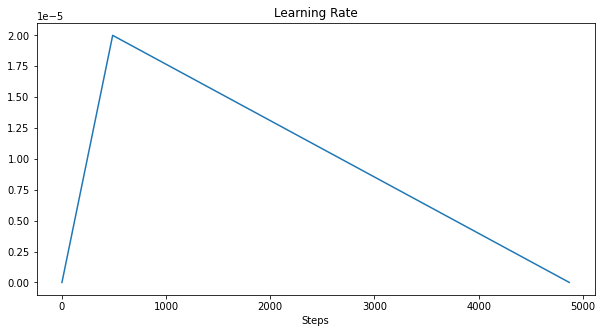

In [ ]:
num_epochs = 10
total_steps = len(train_loader) * num_epochs
optimizer = torch.optim.Adam(model_0.parameters(), lr=2e-5)

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = len(train_loader), #0 Default value in run_glue.py
                                           num_training_steps = total_steps)
print(total_steps)
lrs = []

for i in range(total_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])

    scheduler.step()

plt.figure(figsize=(10,5))
plt.title('Learning Rate')
plt.xlabel('Steps')
plt.plot(range(total_steps), lrs)
plt.show()

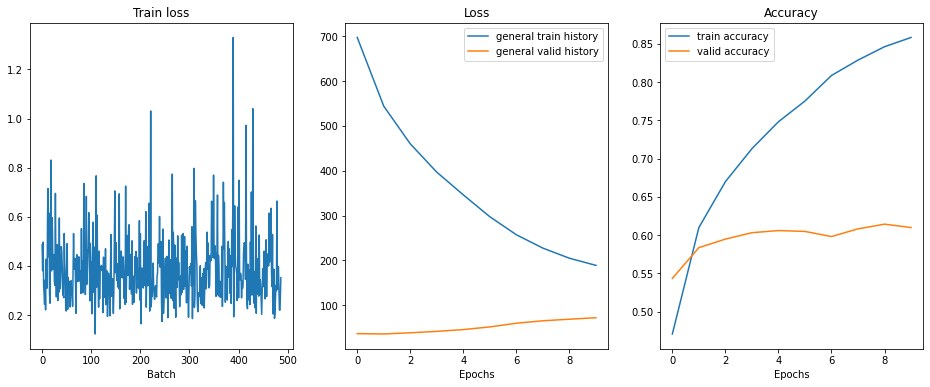

Epoch: 10 | Time: 3m 39s
Train Loss: 0.387, Train Acc: 0.858,
Valid Loss: 2.565, Valid Acc: 0.610


In [48]:
!CUDA_LAUNCH_BLOCKING = 1

TG_NOTIFY_CHAT_ID = -1
TG_NOTIFY_TOKEN = ''
tg = TG(TG_NOTIFY_TOKEN, TG_NOTIFY_CHAT_ID)

clip = 1.0

weights = torch.Tensor(class_weight.compute_class_weight('balanced', classes=np.unique(df["toxicity"]), y=df["toxicity"])).type(torch.float32)

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 5, 
                                           num_training_steps = total_steps)
history = training(model_0, train_loader, valid_loader, criterion, optimizer, num_epochs, clip, scheduler)

In [49]:
# Testing
test_acc = 0
model_0.eval()
number_samples = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = batch["input_ids"].to(device)
        labels = batch["target"].to(device)
        attention_masks = batch["mask"].to(device)
        output = model_0(input_ids=inputs, attention_mask=attention_masks)
        preds = torch.argmax(output.logits, dim=1) 
        test_acc += (labels==preds).sum().item() / len(labels)
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/28 [00:00<?, ?it/s]

Test Acc: 0.6300223214285714


In [50]:
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('submission.csv')
dataset = TweetDataset(test, tokenizer=tokenizer, max_length=128, mode='test') 
final_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [51]:
model_0.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(final_test_loader):
        inputs = batch["input_ids"].to(device)
        attention_masks = batch["mask"].to(device)
        output = model_0(input_ids=inputs, attention_mask=attention_masks)
        preds = torch.argmax(output.logits, dim=1) 
        predictions.extend(preds.cpu().numpy())

  0%|          | 0/144 [00:00<?, ?it/s]

In [52]:
sub['prediction'] = predictions
sub.to_csv('submission1.csv', index=False)

In [55]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
    sys.path += ['bertviz_repo']

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [56]:
from bertviz import model_view
def call_html():
    import IPython
    
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [58]:
text = df['comment_text'][3] 
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True).to(device)
input_ids = inputs['input_ids']
attention = model_0(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

## Fine-tuning Model 2


In [59]:
seed = 43

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Downloading:   0%|          | 0.00/336M [00:00<?, ?B/s]

In [61]:
clip = 1.0
num_epochs = 10
lr = 2e-5 # learning rate
total_steps = len(train_loader) * num_epochs
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
weights = torch.Tensor(class_weight.compute_class_weight('balanced', classes=np.unique(df["toxicity"]), y=df["toxicity"])).type(torch.float32)

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 4, 
                                            num_training_steps = total_steps)

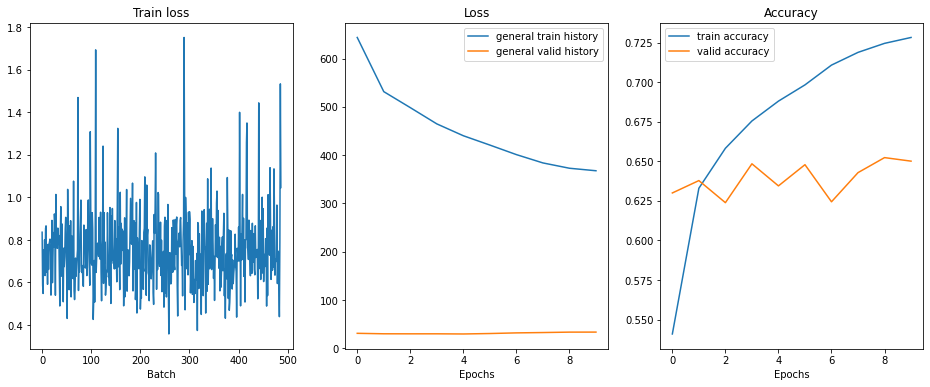

Epoch: 10 | Time: 3m 38s
Train Loss: 0.755, Train Acc: 0.728,
Valid Loss: 1.205, Valid Acc: 0.650


In [62]:
!CUDA_LAUNCH_BLOCKING = 1

history_1 = training(model_1, train_loader, valid_loader, criterion, optimizer, num_epochs, clip, scheduler)

In [63]:
# Testing
test_acc = 0
model_1.eval()
number_samples = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = batch["input_ids"].to(device)
        labels = batch["target"].to(device)
        attention_masks = batch["mask"].to(device)
        output = model_1(input_ids=inputs, attention_mask=attention_masks)
        preds = torch.argmax(output.logits, dim=1) 
        test_acc += (labels==preds).sum().item() / len(labels)
print(f"Test Acc: {(test_acc / len(test_loader)):.3f}")

  0%|          | 0/28 [00:00<?, ?it/s]

Test Acc: 0.640


In [64]:
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('submission.csv')
dataset = TweetDataset(test, tokenizer=tokenizer, max_length=128, mode='test') 
final_test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [65]:
model_1.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(final_test_loader):
        inputs = batch["input_ids"].to(device)
        attention_masks = batch["mask"].to(device)
        output = model_1(input_ids=inputs, attention_mask=attention_masks)
        preds = torch.argmax(output.logits, dim=1) 
        predictions.extend(preds.cpu().numpy())

  0%|          | 0/144 [00:00<?, ?it/s]

In [66]:
sub['prediction'] = predictions 
sub.to_csv('submission2.csv', index=False)

In [68]:
text = df["comment_text"][3]
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True).to(device)
input_ids = inputs['input_ids']
attention = model_1(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [74]:
# Experiments with tweet lengths

data = [["0_model", 128, 5, 80, 10, 0.8, 0.645, 0.6423],
        ["1_model", 128, 5, 80, 10, 0.8, 0.652, 0.658], 
        ["0_model", 100, 5, 64, 10, 0.9, 0.6359, 0.66], 
        ["1_model", 100, 5, 64, 10, 0.9,0.655,0.653]]
result = pd.DataFrame(data, columns=['model', 'max_length', 'warm_up', 'batch_size', 'num_epochs', 'train_size', 'test_accuracy', 'leaderboard'])
result                

,model,max_length,warm_up,batch_size,num_epochs,train_size,test_accuracy,leaderboard
0,0_model,128,5,80,10,0.8,0.6450,0.6423
1,1_model,128,5,80,10,0.8,0.6520,0.6580
2,0_model,100,5,64,10,0.9,0.6359,0.6600
3,1_model,100,5,64,10,0.9,0.6550,0.6530
